# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [7]:
# Import libraries

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense,Dropout,LSTM,GRU
from tensorflow.keras.optimizers import Adam
# Utility
from datetime import datetime
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [11]:
# Define a function to load data and aggregate them

def merge_stock_data(file_list):
    """
    This function takes multiple CSV files  and combines them to a single Data frame.

    Args:
        file_list (list): List of file paths CSV files.

    Returns:
        pd.DataFrame: Merged DataFrame with Date and Close prices for each stock.
    """
    combined_df = None
    
    for file in file_list:
        # Extract stock name from the filename (e.g., "AMZN" from "AMZN_stock_data.csv")
        stock_name = os.path.basename(file).split('_')[0]
        
        # Read CSV
        df = pd.read_csv(file, parse_dates=["Date"])
        
        # Keep only Date and Close columns, rename Close to the stock name
        df = df[["Date", "Close"]].rename(columns={"Close": stock_name})
        
        # Merge with combined DataFrame on Date
        if combined_df is None:
            combined_df = df
        else:
            combined_df = pd.merge(combined_df, df, on="Date", how="inner")
    
    # Sort by date
    combined_df = combined_df.sort_values("Date").reset_index(drop=True)
    
    return combined_df

In [12]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
file_list = [
    "./RNN_Stocks_Data/AMZN_stocks_data.csv",
    "./RNN_Stocks_Data/GOOGL_stocks_data.csv",
    "./RNN_Stocks_Data/IBM_stocks_data.csv",
    "./RNN_Stocks_Data/MSFT_stocks_data.csv"
]

stock_close_df = merge_stock_data(file_list)
print(stock_close_df.head())


        Date   AMZN   GOOGL    IBM   MSFT
0 2006-01-03  47.58  217.83  82.06  26.84
1 2006-01-04  47.25  222.84  81.95  26.97
2 2006-01-05  47.65  225.85  82.50  26.99
3 2006-01-06  47.87  233.06  84.95  26.91
4 2006-01-09  47.08  233.68  83.73  26.86


In [13]:
# View specifics of the data

# Check the shape (rows, columns)
print("Shape of the DataFrame:", stock_close_df.shape)

# View the first few rows
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print(stock_close_df.head())

# Get summary statistics (mean, std, min, max, etc.)
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - -")

print(stock_close_df.describe())

# Get a concise summary (column names, data types, non-null counts)
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print(stock_close_df.info())


Shape of the DataFrame: (3019, 5)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        Date   AMZN   GOOGL    IBM   MSFT
0 2006-01-03  47.58  217.83  82.06  26.84
1 2006-01-04  47.25  222.84  81.95  26.97
2 2006-01-05  47.65  225.85  82.50  26.99
3 2006-01-06  47.87  233.06  84.95  26.91
4 2006-01-09  47.08  233.68  83.73  26.86
- - - - - - - - - - - - - - - - - - - - - - - - - - - - -
                                Date         AMZN        GOOGL          IBM  \
count                           3019  3019.000000  3019.000000  3019.000000   
mean   2012-01-01 20:00:33.388539392   299.376231   428.044001   145.623031   
min              2006-01-03 00:00:00    26.070000   128.850000    71.740000   
25%              2009-01-01 00:00:00    81.090000   247.605000   116.520000   
50%              2011-12-30 00:00:00   205.440000   310.080000   149.330000   
75%              2015-01-01 00:00:00   375.140000   570.770000   178.690000   
max              2017-12-29 00:00:00  1195.83

## Observation

There are total 3019 rows 

The mean value of Google stock is higher compare to others 

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [16]:
# Handle Missing Values

# Count missing values in each column
print(stock_close_df.isnull().sum())

Date     0
AMZN     0
GOOGL    0
IBM      0
MSFT     0
dtype: int64


### Observation

No missing values 

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

In [20]:
# Frequency distribution of volumes

# Load CSV files again to extract 'Volume'
amzn = pd.read_csv("./RNN_Stocks_Data/AMZN_stocks_data.csv", parse_dates=["Date"])
googl = pd.read_csv("./RNN_Stocks_Data/GOOGL_stocks_data.csv", parse_dates=["Date"])
ibm = pd.read_csv("./RNN_Stocks_Data/IBM_stocks_data.csv", parse_dates=["Date"])
msft = pd.read_csv("./RNN_Stocks_Data/MSFT_stocks_data.csv", parse_dates=["Date"])

# Keep only Date and Volume, add stock name to column
amzn_vol = amzn[["Date", "Volume"]].rename(columns={"Volume": "AMZN_Volume"})
googl_vol = googl[["Date", "Volume"]].rename(columns={"Volume": "GOOGL_Volume"})
ibm_vol = ibm[["Date", "Volume"]].rename(columns={"Volume": "IBM_Volume"})
msft_vol = msft[["Date", "Volume"]].rename(columns={"Volume": "MSFT_Volume"})

# Merge all on Date
stock_volume_df = amzn_vol.merge(googl_vol, on="Date").merge(ibm_vol, on="Date").merge(msft_vol, on="Date")

In [21]:
print(stock_volume_df.describe())

                                Date   AMZN_Volume  GOOGL_Volume  \
count                           3019  3.019000e+03  3.019000e+03   
mean   2012-01-01 20:00:33.388539392  5.931712e+06  3.551504e+06   
min              2006-01-03 00:00:00  9.864350e+05  5.211410e+05   
25%              2009-01-01 00:00:00  3.137037e+06  1.760854e+06   
50%              2011-12-30 00:00:00  4.724100e+06  2.517630e+06   
75%              2015-01-01 00:00:00  7.135246e+06  4.242182e+06   
max              2017-12-29 00:00:00  1.044046e+08  4.118289e+07   
std                              NaN  5.122034e+06  3.038599e+06   

         IBM_Volume   MSFT_Volume  
count  3.019000e+03  3.019000e+03  
mean   5.773563e+06  5.161762e+07  
min    2.542560e+05  7.425603e+06  
25%    3.622178e+06  3.136557e+07  
50%    4.926500e+06  4.617529e+07  
75%    6.966642e+06  6.322291e+07  
max    3.077428e+07  5.910786e+08  
std    3.193327e+06  3.114958e+07  


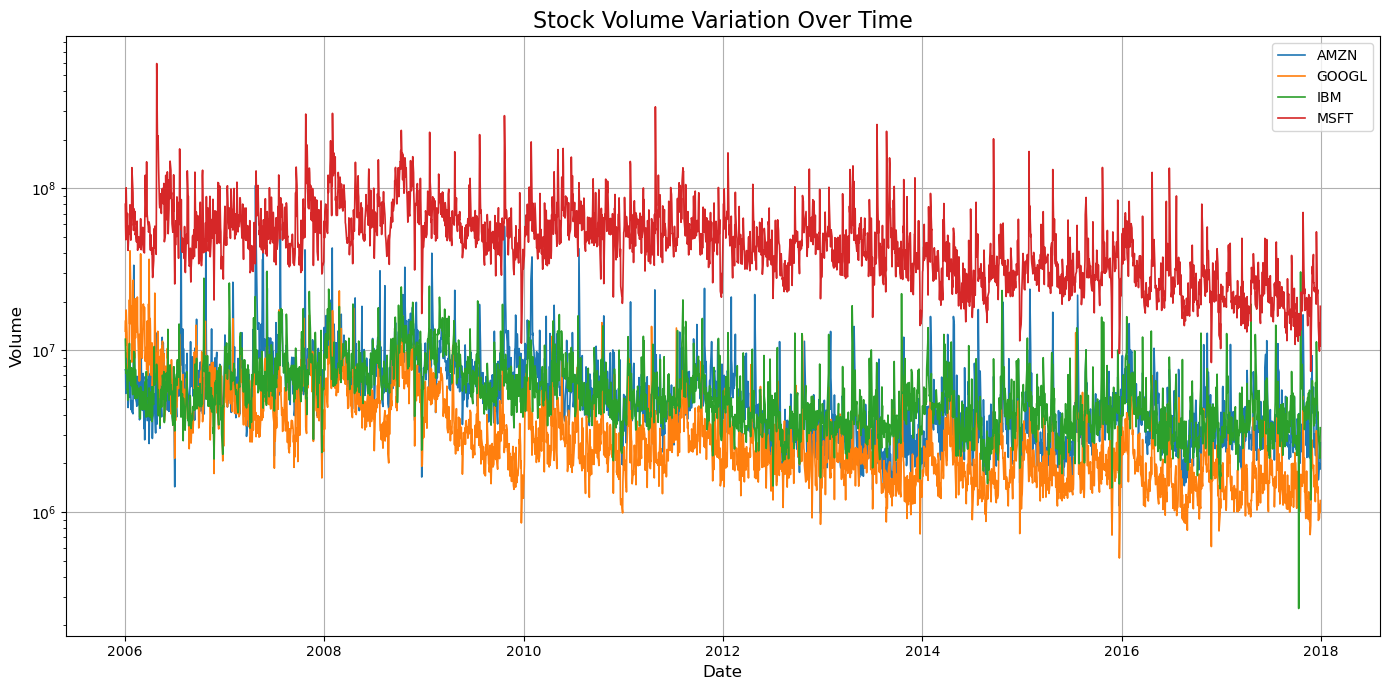

In [49]:
# Stock volume variation over time

# Set the figure size
plt.figure(figsize=(14, 7))

# Plot each stock's volume
plt.plot(stock_volume_df['Date'], stock_volume_df['AMZN_Volume'], label='AMZN', linewidth=1.2)
plt.plot(stock_volume_df['Date'], stock_volume_df['GOOGL_Volume'], label='GOOGL', linewidth=1.2)
plt.plot(stock_volume_df['Date'], stock_volume_df['IBM_Volume'], label='IBM', linewidth=1.2)
plt.plot(stock_volume_df['Date'], stock_volume_df['MSFT_Volume'], label='MSFT', linewidth=1.2)

# Chart decorations
plt.title("Stock Volume Variation Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volume", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


### Observation

1. Microsoft trade volume is always high compare to other 3 between 2006 to 2018 .

2. Google trade volume is always less compare to other 3 between 2006 to 2018 .

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

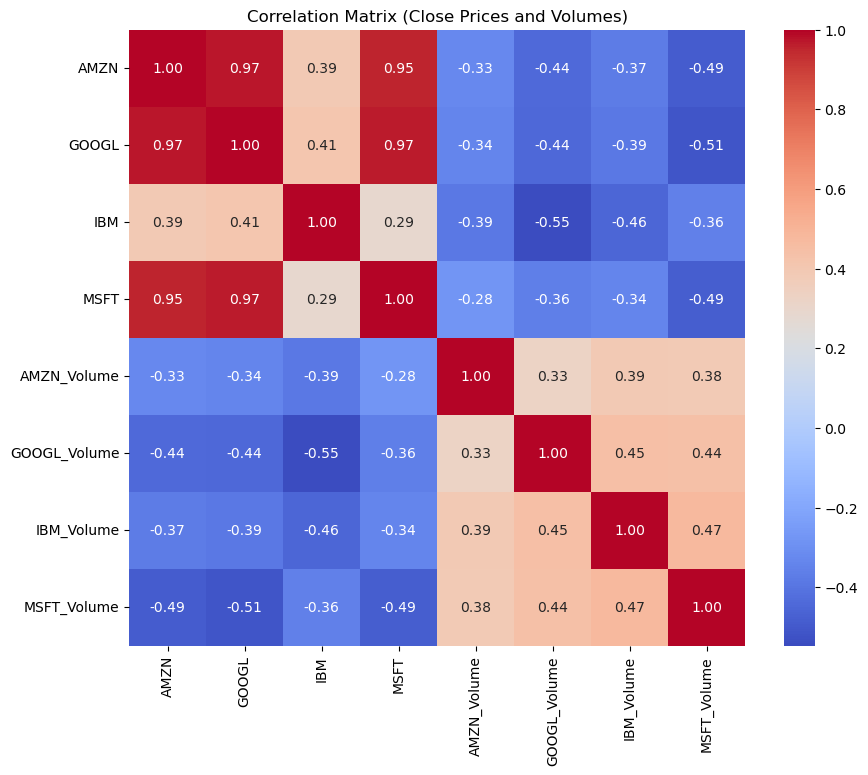

In [53]:
# Analyse correlations

# Merge them into one DataFrame on 'Date'
combined_df = pd.merge(stock_close_df, stock_volume_df, on='Date')
combined_df.head()

# Drop the 'Date' column as it's not numeric
corr_matrix = combined_df.drop(columns='Date').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Close Prices and Volumes)")
plt.show()

### Observation

#### Price-to-Price Correlation

1. Microsoft ,Google and Amazon - Very strong positive correlation — they move almost in sync.

2.Microsoft ,IBM - Lowest correlation among price pairs — IBM has distinct behavior.

Interpretation:

AMZN, GOOGL, and MSFT move together closely, likely due to similar business models .

#### Price vs Volume Correlations

1. You could see closing price with its own volume are negatively related (IBM, GOOGL, and MSFT around -.45 and AMAZON -.33) means Higher trading volumes are often triggered by price drops.

#### Volume-to-Volume Correlations

1. Mild to medium correlation between companies .


### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [55]:
# Define a function that divides the data into windows and generates target variable values for each window

def generate_windowed_data(df, window_size, step_size, target_columns):
    """
    Create windowed feature sets and corresponding targets from a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with time-series data.
    - window_size (int): The number of time steps in each input sequence.
    - step_size (int): The stride length between windows.
    - target_columns (list of str): List of columns to use as targets.

    Returns:
    - X (np.ndarray): Feature array of shape (num_samples, window_size, num_features).
    - y (np.ndarray): Target array of shape (num_samples, len(target_columns)).
    """
    X, y = [], []

    for i in range(0, len(df) - window_size, step_size):
        window = df.iloc[i:i + window_size].values
        targets = df.iloc[i + window_size][target_columns].values
        X.append(window)
        y.append(targets)

    return np.array(X), np.array(y)

In [57]:
combined_df.head()

,Date,AMZN,GOOGL,IBM,MSFT,AMZN_Volume,GOOGL_Volume,IBM_Volume,MSFT_Volume
0,2006-01-03,47.58,217.83,82.06,26.84,7582127,13137450,11715200,79974418
1,2006-01-04,47.25,222.84,81.95,26.97,7440914,15292353,9840600,57975661
2,2006-01-05,47.65,225.85,82.50,26.99,5417258,10815661,7213500,48247610
3,2006-01-06,47.87,233.06,84.95,26.91,6154285,17759521,8197400,100969092
4,2006-01-09,47.08,233.68,83.73,26.86,8945056,12795837,6858200,55627836


In [59]:
df_model = combined_df.drop(columns=['Date'])

In [61]:
df_model.head()

,AMZN,GOOGL,IBM,MSFT,AMZN_Volume,GOOGL_Volume,IBM_Volume,MSFT_Volume
0,47.58,217.83,82.06,26.84,7582127,13137450,11715200,79974418
1,47.25,222.84,81.95,26.97,7440914,15292353,9840600,57975661
2,47.65,225.85,82.50,26.99,5417258,10815661,7213500,48247610
3,47.87,233.06,84.95,26.91,6154285,17759521,8197400,100969092
4,47.08,233.68,83.73,26.86,8945056,12795837,6858200,55627836


In [63]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AMZN          3019 non-null   float64
 1   GOOGL         3019 non-null   float64
 2   IBM           3019 non-null   float64
 3   MSFT          3019 non-null   float64
 4   AMZN_Volume   3019 non-null   int64  
 5   GOOGL_Volume  3019 non-null   int64  
 6   IBM_Volume    3019 non-null   int64  
 7   MSFT_Volume   3019 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 188.8 KB


In [65]:
# Test the function 
target_columns = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
X, y = generate_windowed_data(df_model, window_size=3, step_size=1, target_columns=target_columns)
print(X.shape)
print(y.shape)

(3016, 3, 8)
(3016, 4)


In [67]:
#test a sample window
X[0]

array([[4.7580000e+01, 2.1783000e+02, 8.2060000e+01, 2.6840000e+01,
        7.5821270e+06, 1.3137450e+07, 1.1715200e+07, 7.9974418e+07],
       [4.7250000e+01, 2.2284000e+02, 8.1950000e+01, 2.6970000e+01,
        7.4409140e+06, 1.5292353e+07, 9.8406000e+06, 5.7975661e+07],
       [4.7650000e+01, 2.2585000e+02, 8.2500000e+01, 2.6990000e+01,
        5.4172580e+06, 1.0815661e+07, 7.2135000e+06, 4.8247610e+07]])

In [69]:
#check sample target for the window
y[0]

array([ 47.87, 233.06,  84.95,  26.91])

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [71]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X, y):
   
    # Flatten X to shape (num_windows * window_size, num_features)
    num_windows, window_size, num_features = X.shape
    X_flat = X.reshape(-1, num_features) #

    # Initialize scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Fit scalers
    scaler_X.partial_fit(X_flat)
    scaler_y.partial_fit(y)

    # Transform X and y
    X_scaled = scaler_X.transform(X_flat).reshape(num_windows, window_size, num_features)
    y_scaled = scaler_y.transform(y)

    return X_scaled, y_scaled, scaler_X, scaler_y

# def scale_windowed_data(X, y):

#     # Initialize scalers
#     scaler_X = StandardScaler()
#     scaler_y = StandardScaler()

#     # First pass: incrementally fit scalers
#     for i in range(X.shape[0]):
#         scaler_X.partial_fit(X[i])                    # Fit each time window
#         scaler_y.partial_fit(y[i].reshape(1, -1))     # Fit each y value

#     # Second pass: apply the fitted scalers
#     X_scaled = np.array([scaler_X.transform(window) for window in X])
#     y_scaled = np.array([scaler_y.transform(y_i.reshape(1, -1))[0] for y_i in y])

#     return X_scaled, y_scaled ,scaler_X, scaler_y

In [73]:
X_scaled, y_scaled ,scaler_X, scaler_y= scale_windowed_data(X, y)

print(X_scaled.shape)  # (3016, 3, 8)
print(y_scaled.shape)  # (3016, 4)  # if you're predicting 4 stock closing prices


(3016, 3, 8)
(3016, 4)


In [75]:
y_scaled[0]

array([-0.89925924, -0.82590817, -1.61992043, -0.65410092])

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [77]:
# Define a function to create input and output data points from the master DataFrame

def prepare_rnn_data(df, target_columns, window_size=3, step_size=1, test_ratio=0.2):
    """
    Main function to create windowed data, split and scale it for RNN.
    """
    # Generate windows
    X, y = generate_windowed_data(df, window_size, step_size, target_columns)
    print("generate_windowed_data - X shape: {}, y shape: {}".format(X.shape, y.shape))
    
    # Step 2: Train-Test Split BEFORE scaling to avoid leakage
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False
    )

    # Step 3: Scale each part separately
    X_train_scaled, y_train_scaled, scaler_X, scaler_y = scale_windowed_data(X_train, y_train)

    # Apply the same scalers to test data
    X_test_scaled = np.array([scaler_X.transform(window) for window in X_test])
    y_test_scaled = np.array([scaler_y.transform(y_i.reshape(1, -1))[0] for y_i in y_test])

    return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [79]:
# Checking for patterns in different sequence lengths
combined_df.info()
combined_df.set_index('Date', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3019 non-null   datetime64[ns]
 1   AMZN          3019 non-null   float64       
 2   GOOGL         3019 non-null   float64       
 3   IBM           3019 non-null   float64       
 4   MSFT          3019 non-null   float64       
 5   AMZN_Volume   3019 non-null   int64         
 6   GOOGL_Volume  3019 non-null   int64         
 7   IBM_Volume    3019 non-null   int64         
 8   MSFT_Volume   3019 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 212.4 KB


/var/folders/59/3lgdlqjx671dkbdyhqp7mp_00000gp/T/ipykernel_4971/324696232.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  amzn_monthly = combined_df['AMZN'].resample('M').mean()
/var/folders/59/3lgdlqjx671dkbdyhqp7mp_00000gp/T/ipykernel_4971/324696232.py:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  amzn_quarterly = combined_df['AMZN'].resample('Q').mean()


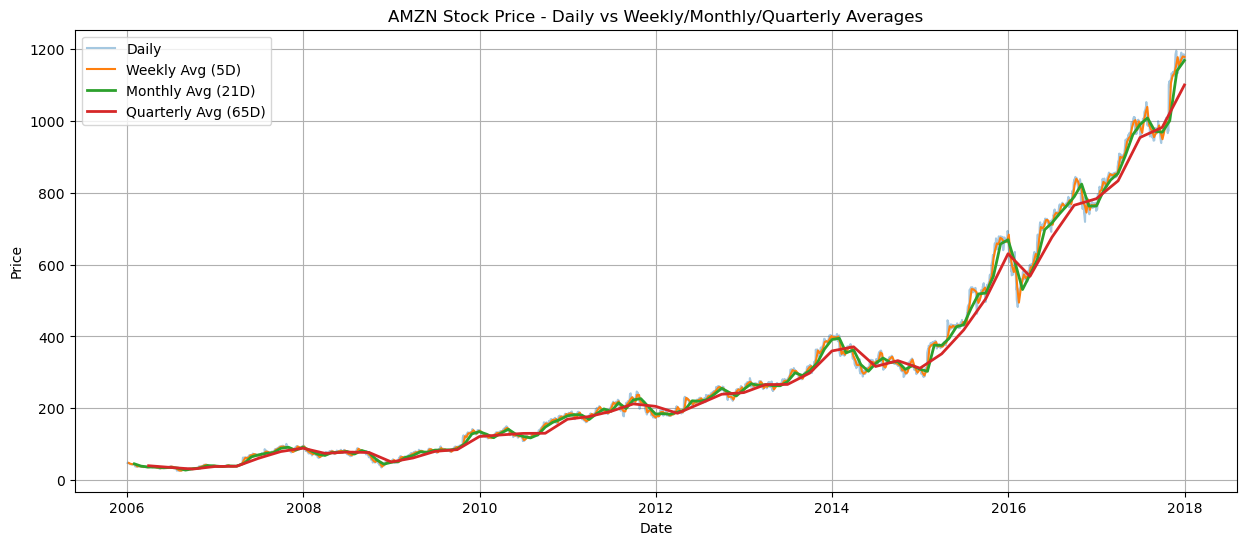

In [81]:
amzn_weekly = combined_df['AMZN'].resample('W').mean()
amzn_monthly = combined_df['AMZN'].resample('M').mean()
amzn_quarterly = combined_df['AMZN'].resample('Q').mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(combined_df['AMZN'], label='Daily', alpha=0.4)
plt.plot(amzn_weekly, label='Weekly Avg (5D)', linewidth=1.5)
plt.plot(amzn_monthly, label='Monthly Avg (21D)', linewidth=2)
plt.plot(amzn_quarterly, label='Quarterly Avg (65D)', linewidth=2)

plt.title("AMZN Stock Price - Daily vs Weekly/Monthly/Quarterly Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

### Observation
From the above graph don't see much variation 
Lets do the correlation analysis

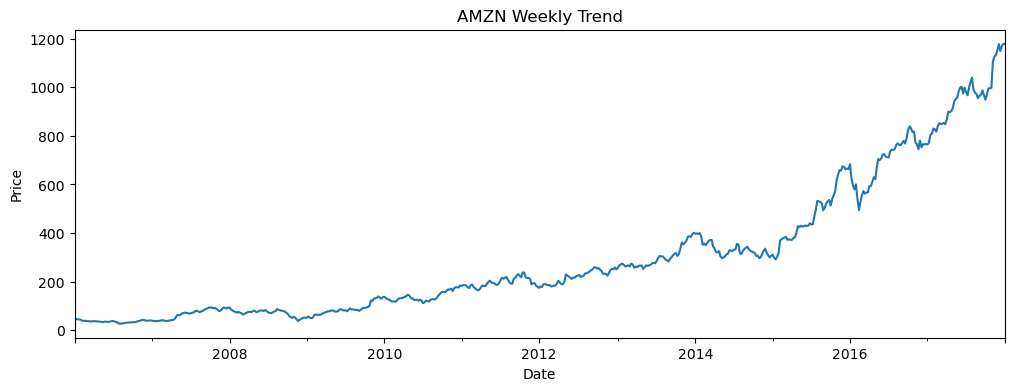

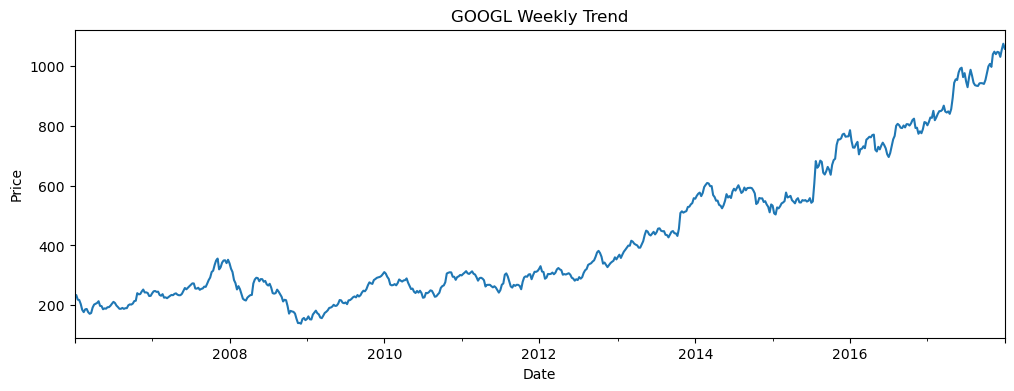

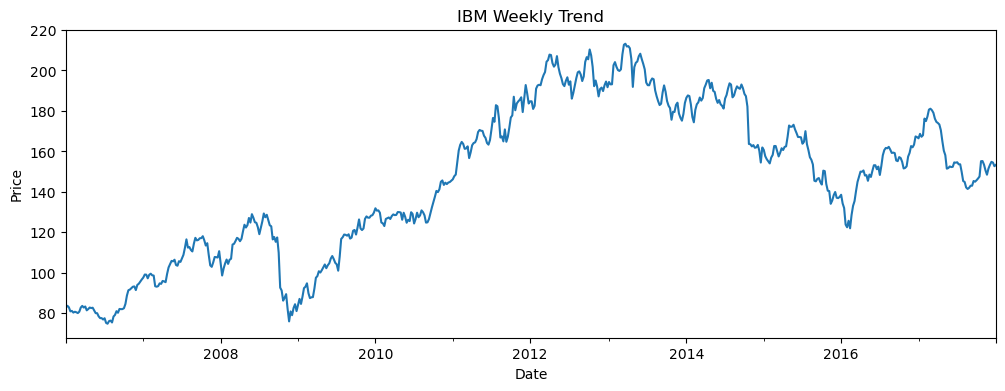

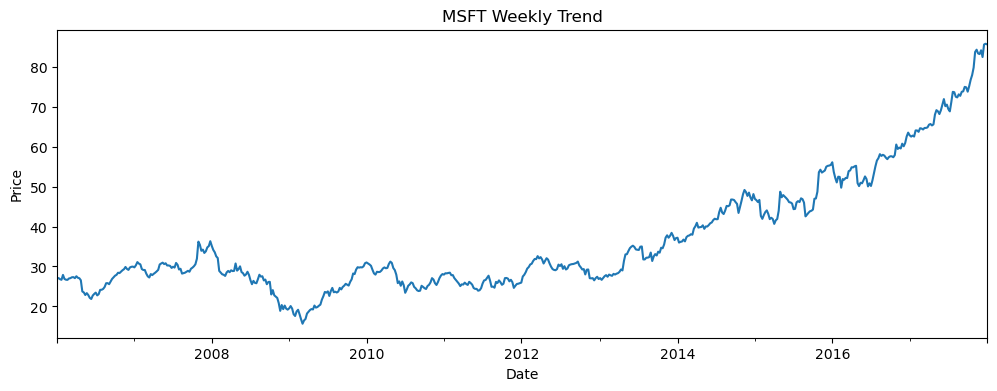

/var/folders/59/3lgdlqjx671dkbdyhqp7mp_00000gp/T/ipykernel_4971/576144013.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  combined_df[col].resample(freq).mean().plot(title=f"{col} {label} Trend")


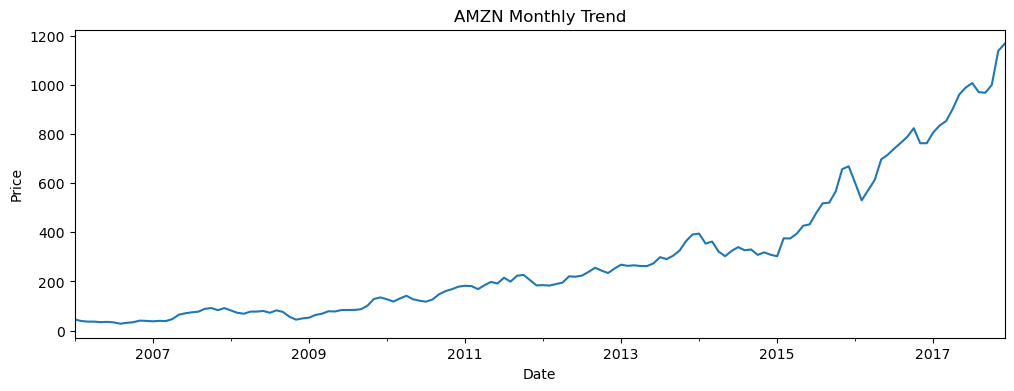

/var/folders/59/3lgdlqjx671dkbdyhqp7mp_00000gp/T/ipykernel_4971/576144013.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  combined_df[col].resample(freq).mean().plot(title=f"{col} {label} Trend")


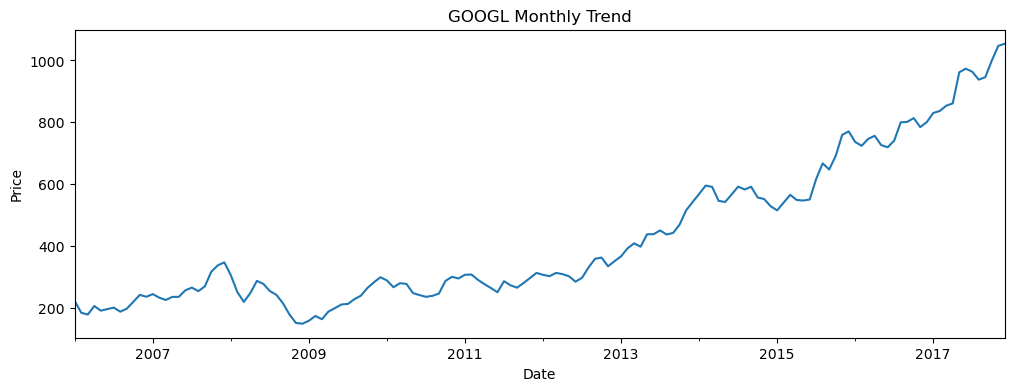

/var/folders/59/3lgdlqjx671dkbdyhqp7mp_00000gp/T/ipykernel_4971/576144013.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  combined_df[col].resample(freq).mean().plot(title=f"{col} {label} Trend")


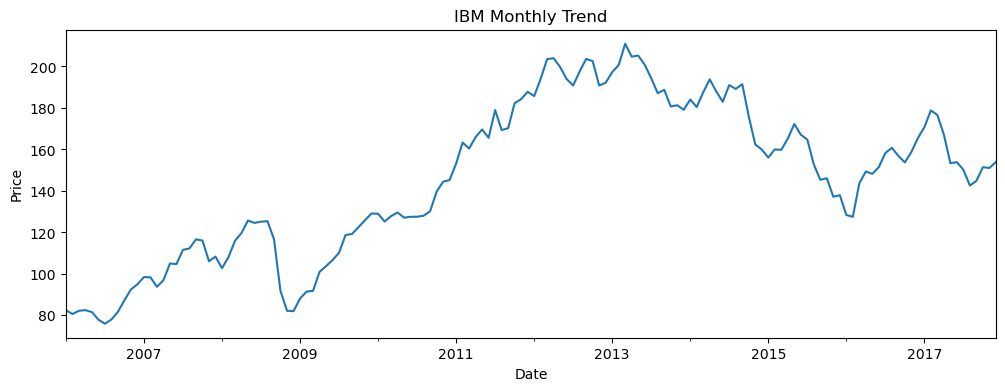

/var/folders/59/3lgdlqjx671dkbdyhqp7mp_00000gp/T/ipykernel_4971/576144013.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  combined_df[col].resample(freq).mean().plot(title=f"{col} {label} Trend")


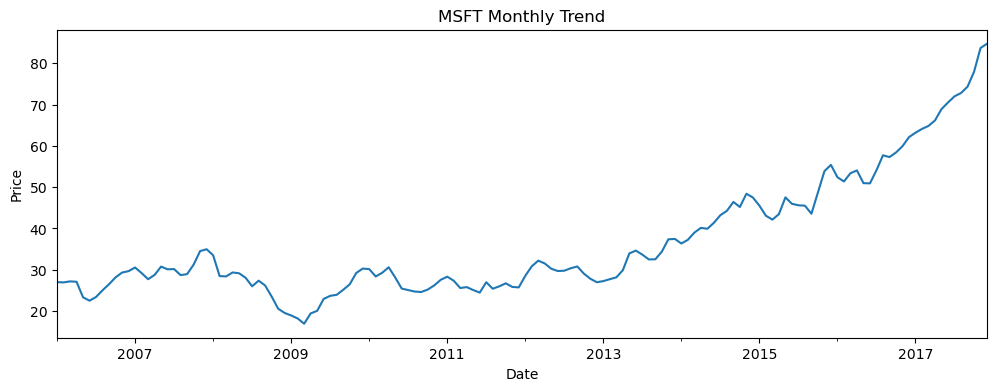

/var/folders/59/3lgdlqjx671dkbdyhqp7mp_00000gp/T/ipykernel_4971/576144013.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  combined_df[col].resample(freq).mean().plot(title=f"{col} {label} Trend")


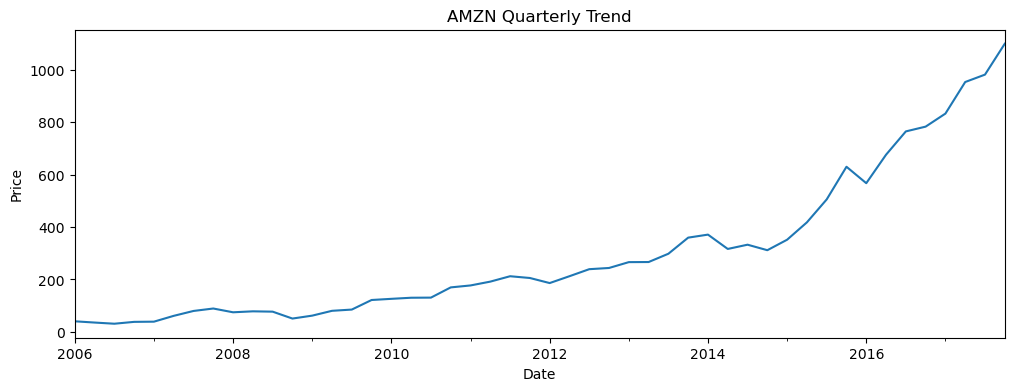

/var/folders/59/3lgdlqjx671dkbdyhqp7mp_00000gp/T/ipykernel_4971/576144013.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  combined_df[col].resample(freq).mean().plot(title=f"{col} {label} Trend")


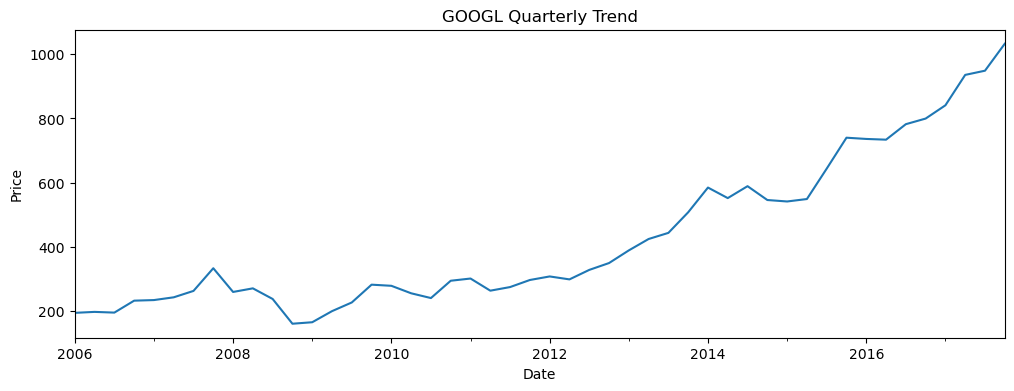

/var/folders/59/3lgdlqjx671dkbdyhqp7mp_00000gp/T/ipykernel_4971/576144013.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  combined_df[col].resample(freq).mean().plot(title=f"{col} {label} Trend")


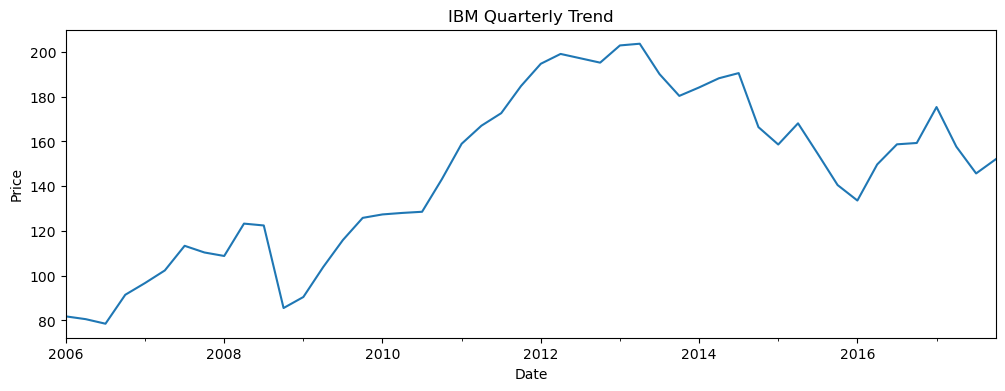

/var/folders/59/3lgdlqjx671dkbdyhqp7mp_00000gp/T/ipykernel_4971/576144013.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  combined_df[col].resample(freq).mean().plot(title=f"{col} {label} Trend")


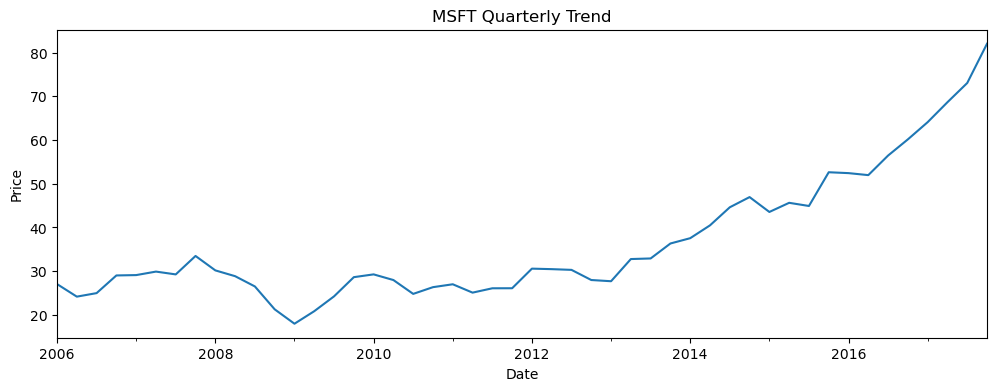

In [83]:
resample_freqs = {'Weekly': 'W', 'Monthly': 'M', 'Quarterly': 'Q'}
for label, freq in resample_freqs.items():
    for col in ['AMZN', 'GOOGL', 'IBM', 'MSFT']:
        plt.figure(figsize=(12, 4))
        combined_df[col].resample(freq).mean().plot(title=f"{col} {label} Trend")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.show()

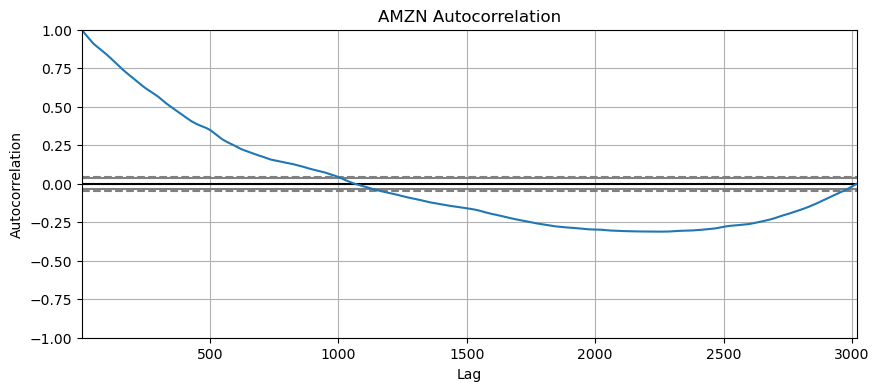

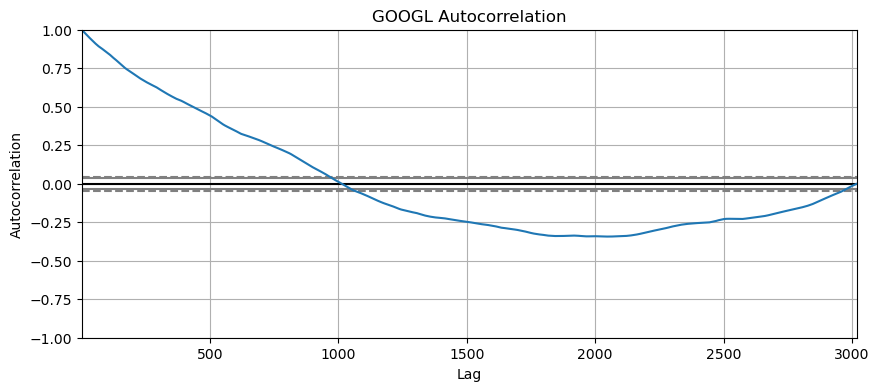

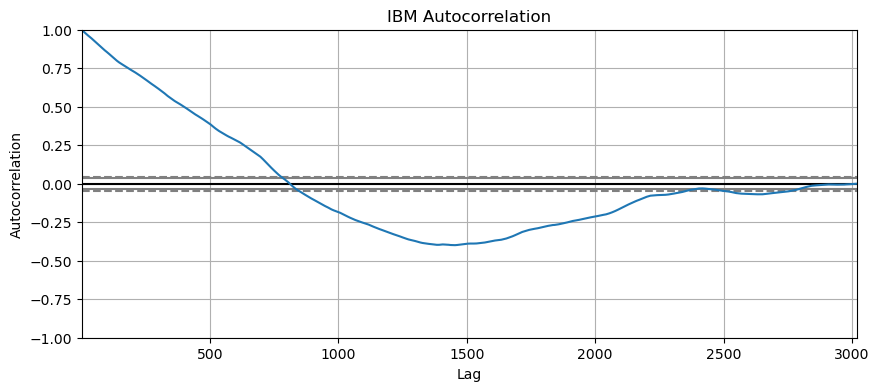

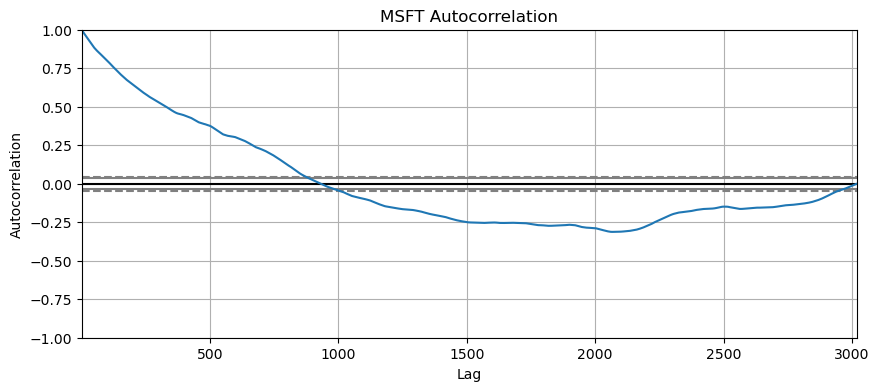

In [85]:
from pandas.plotting import autocorrelation_plot

for col in ['AMZN', 'GOOGL', 'IBM', 'MSFT']:
    plt.figure(figsize=(10, 4))
    autocorrelation_plot(combined_df[col].dropna())
    plt.title(f"{col} Autocorrelation")
    plt.show()

In [87]:
combined_df

,AMZN,GOOGL,IBM,MSFT,AMZN_Volume,GOOGL_Volume,IBM_Volume,MSFT_Volume
Date,,,,,,,,
2006-01-03,47.58,217.83,82.06,26.84,7582127,13137450,11715200,79974418
2006-01-04,47.25,222.84,81.95,26.97,7440914,15292353,9840600,57975661
2006-01-05,47.65,225.85,82.50,26.99,5417258,10815661,7213500,48247610
2006-01-06,47.87,233.06,84.95,26.91,6154285,17759521,8197400,100969092
2006-01-09,47.08,233.68,83.73,26.86,8945056,12795837,6858200,55627836
...,...,...,...,...,...,...,...,...
2017-12-22,1168.36,1068.86,152.50,85.51,1585054,889446,2990583,14145841
2017-12-26,1176.76,1065.85,152.83,85.40,2005187,918767,2479017,9891237
2017-12-27,1182.26,1060.20,153.13,85.71,1867208,1116203,2149257,14678025


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [89]:
# Create data instances from the master data frame using decided window size and window stride

target_columns = ['AMZN', 'GOOGL', 'MSFT', 'IBM']

X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = prepare_rnn_data(
    df_model,
    target_columns=target_columns,
    window_size=21,
    step_size=1,
    test_ratio=0.2
)

generate_windowed_data - X shape: (2998, 21, 8), y shape: (2998, 4)


In [91]:
# Check the number of data points generated
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train_scaled shape:", y_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_test_scaled shape:", y_test_scaled.shape)
print("Data types:", X_train_scaled.dtype, y_train_scaled.dtype)

X_train_scaled shape: (2398, 21, 8)
y_train_scaled shape: (2398, 4)
X_test_scaled shape: (600, 21, 8)
y_test_scaled shape: (600, 4)
Data types: float64 float64


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [93]:
# Check if the datasets are compatible inputs to neural networks

assert X_train_scaled.shape[1:] == X_test_scaled.shape[1:], "Mismatch in input window size or features"
assert y_train_scaled.shape[1] == y_test_scaled.shape[1], "Mismatch in target size"

## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [95]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def create_rnn_model(input_shape, output_size, units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(SimpleRNN(units=units, activation='tanh', input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_size))  # For multi-output regression
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [107]:
# Find an optimal configuration of simple RNN

import itertools

# Hyperparameter options
unit_options = [32, 64 ,128]
dropout_options = [0.1, 0.2,0.3]
lr_options = [0.001, 0.0005]

best_model = None
best_val_loss = float('inf')

input_shape = X_train_scaled.shape[1:]  # (window_size, num_features)
output_size = y_train_scaled.shape[1]   # number of target companies

for units, dropout, lr in itertools.product(unit_options, dropout_options, lr_options):
    print(f"Training model with units={units}, dropout={dropout}, lr={lr}")
    model = create_rnn_model(input_shape, output_size, units, dropout, lr)
    
    history= model.fit(
        X_train_scaled, y_train_scaled,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    print(f"Validation loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_params = (units, dropout, lr)

Training model with units=32, dropout=0.1, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.0599
Training model with units=32, dropout=0.1, lr=0.0005
Validation loss: 0.0841
Training model with units=32, dropout=0.2, lr=0.001
Validation loss: 0.0726
Training model with units=32, dropout=0.2, lr=0.0005
Validation loss: 0.0759
Training model with units=32, dropout=0.3, lr=0.001
Validation loss: 0.0881
Training model with units=32, dropout=0.3, lr=0.0005
Validation loss: 0.1039
Training model with units=64, dropout=0.1, lr=0.001
Validation loss: 0.0244
Training model with units=64, dropout=0.1, lr=0.0005
Validation loss: 0.0325
Training model with units=64, dropout=0.2, lr=0.001
Validation loss: 0.0314
Training model with units=64, dropout=0.2, lr=0.0005
Validation loss: 0.0326
Training model with units=64, dropout=0.3, lr=0.001
Validation loss: 0.0489
Training model with units=64, dropout=0.3, lr=0.0005
Validation loss: 0.0605
Training model with units=128, dropout=0.1, lr=0.001
Validation loss: 0.0127
Training model with units=128, dropout=0.1, lr=0.0005
Val

In [103]:
best_model

In [109]:
# Find the best configuration based on evaluation metrics

test_loss, test_mae = best_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print("\nBest Hyperparameters:")
print(f"Units: {best_params[0]}, Dropout: {best_params[1]}, Learning Rate: {best_params[2]}")
print(f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


Best Hyperparameters:
Units: 128, Dropout: 0.1, Learning Rate: 0.001
Test MSE: 1.9904, Test MAE: 1.0506


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [111]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

def build_final_rnn_model(input_shape, output_size):
    model = Sequential()
    model.add(SimpleRNN(units=best_params[0], activation='tanh', input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Dense(output_size))  # One output per target (e.g., AMZN, GOOGL, etc.)

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

input_shape = X_train_scaled.shape[1:]
output_size = y_train_scaled.shape[1]

model = build_final_rnn_model(input_shape, output_size)

model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2637 - mae: 0.3662 - val_loss: 0.1164 - val_mae: 0.2681
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0521 - mae: 0.1760 - val_loss: 0.0838 - val_mae: 0.2289
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0340 - mae: 0.1435 - val_loss: 0.0506 - val_mae: 0.1574
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0276 - mae: 0.1264 - val_loss: 0.0546 - val_mae: 0.1776
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0238 - mae: 0.1166 - val_loss: 0.0403 - val_mae: 0.1466
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - mae: 0.1052 - val_loss: 0.0416 - val_mae: 0.1494
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175 - mae: 0.0994 - val_loss: 0.0409 - val_mae: 0.1500
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - mae: 0.0916 - val_loss: 0.0288 - val_mae: 0.1243
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - mae: 0.0

Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


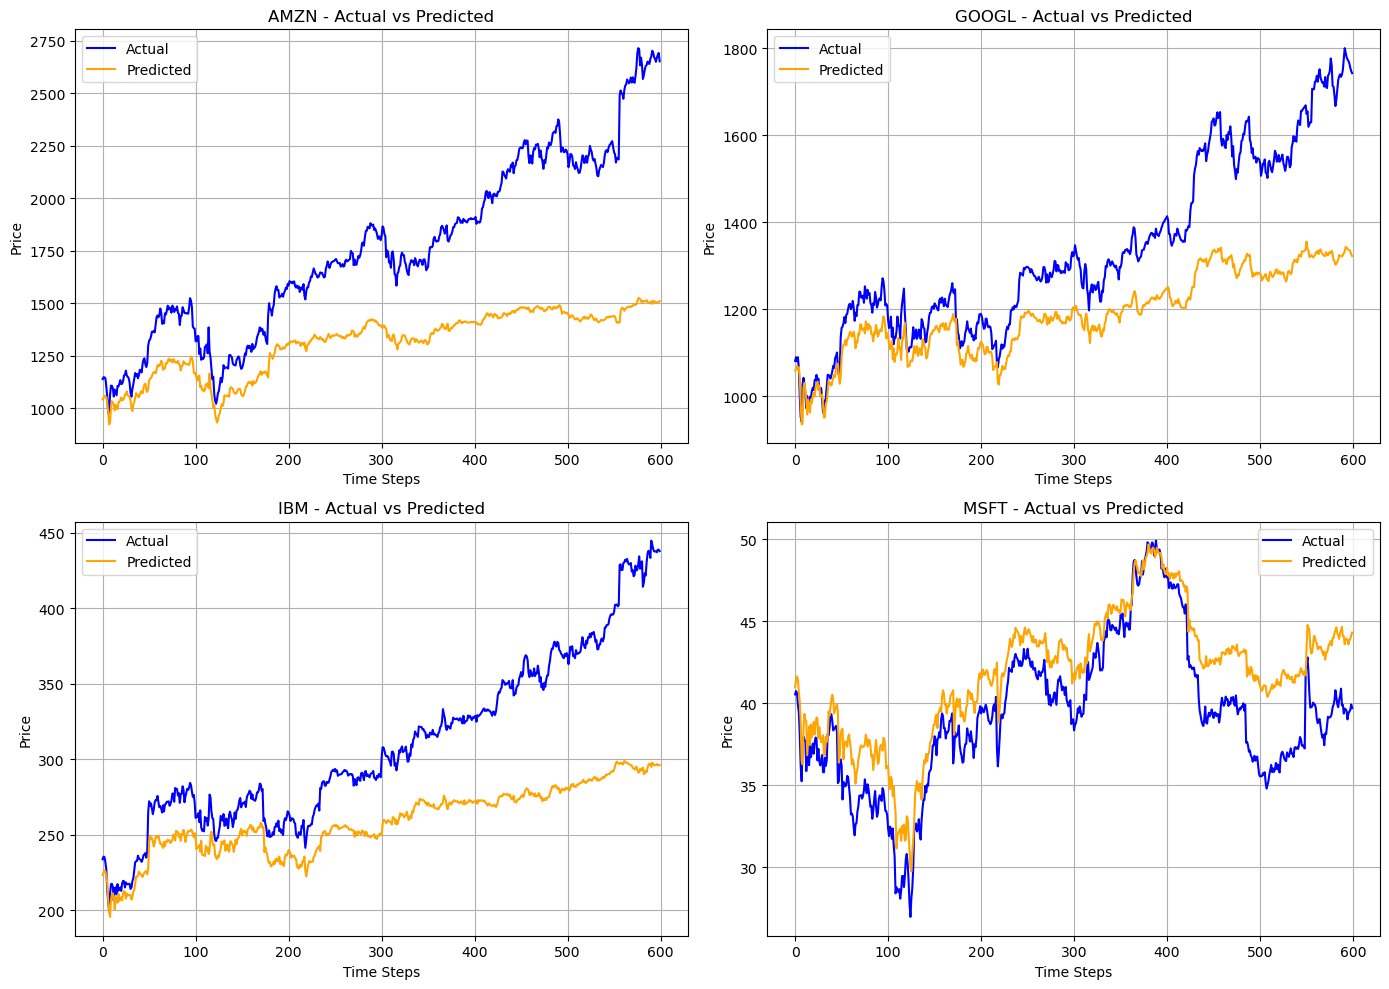

In [115]:
# Predict on the test data and plot
# 1. Predict using the final model
y_pred_scaled = model.predict(X_test_scaled)

# 2. Inverse transform predictions and actual targets
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

# 3. Plotting actual vs predicted for each company
company_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

plt.figure(figsize=(14, 10))
for i in range(y_pred.shape[1]):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_true[:, i], label='Actual', color='blue')
    plt.plot(y_pred[:, i], label='Predicted', color='orange')
    plt.title(f"{company_names[i]} - Actual vs Predicted")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [119]:
# Compute the performance of the model on the testing data set

# Predict on test data
y_pred_scaled = model.predict(X_test_scaled)

# Inverse scale both predictions and true values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

# Compute metrics for each target company
for i, company in enumerate(['AMZN', 'GOOGL', 'IBM', 'MSFT']):
    mse = mean_squared_error(y_true[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    
    print(f"--- {company} ---")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}\n")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
--- AMZN ---
MAE  : 450.6539
MSE  : 286836.4088
RMSE : 535.5711
R²   : -0.5861

--- GOOGL ---
MAE  : 146.4920
MSE  : 34472.8122
RMSE : 185.6686
R²   : 0.1727

--- IBM ---
MAE  : 50.9663
MSE  : 3869.1027
RMSE : 62.2021
R²   : -0.1912

--- MSFT ---
MAE  : 2.4866
MSE  : 8.1927
RMSE : 2.8623
R²   : 0.5815



### Observation

It seems from the graph the model is diverging after ~200 time steps 

A Simple RNN with 64 units may be too shallow to capture long-term dependencies.

RNNs struggle with long sequences.

Gradients from later steps become too small to update early weights effectively.

It learns short-term patterns, not long-term trends.

In [121]:
print("Predicted shape:", y_pred.shape)
print("Actual shape:", y_true.shape)

# View some values
print("Predicted values (first 20):\n", y_pred[:20])
print("Actual values (first 20):\n", y_true[:20])

Predicted shape: (600, 4)
Actual shape: (600, 4)
Predicted values (first 20):
 [[1042.6927   1058.8564    223.24353    40.977303]
 [1050.3656   1063.4098    224.95941    41.45087 ]
 [1060.0284   1069.5664    226.34999    41.639473]
 [1055.457    1060.3468    225.55481    41.432705]
 [1053.7671   1067.0813    222.81238    40.676926]
 [1023.40515  1040.6451    217.98024    40.058987]
 [ 983.30365   984.2932    206.14635    38.82745 ]
 [ 923.3982    935.524     199.38081    36.489048]
 [ 932.9981    937.71765   195.52557    36.2806  ]
 [1004.1959   1020.3156    206.29297    38.44457 ]
 [1033.4163   1030.5969    210.5194     39.35157 ]
 [1026.4357   1014.5572    211.1113     38.96172 ]
 [1019.52185   994.80316   209.0789     38.921345]
 [ 990.6241    958.3393    200.54684    36.839745]
 [1015.45825   991.93164   208.39107    37.726856]
 [1009.4347    977.78326   208.44073    38.59682 ]
 [ 995.60474   962.65173   204.88913    37.460403]
 [1029.1038    992.6617    210.74438    38.704666]
 [1

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [123]:
# # Define a function to create a model and specify default values for hyperparameters
def build_model(model_type='LSTM', units=128, dropout=0.1, lr=0.001, input_shape=(21, 8), output_dim=4):
    model = Sequential()

    if model_type == 'LSTM':
        model.add(LSTM(units, input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(units, input_shape=input_shape))

    model.add(Dropout(dropout))
    model.add(Dense(output_dim))

    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [125]:
# Find an optimal configuration
best_score = float('inf')
best_params = {}
results = []

for model_type in ['LSTM', 'GRU']:
    for units in [32, 64, 128]:
        for dropout in [0.1, 0.2]:
            for lr in [0.001, 0.0005]:
                print(f"Training {model_type} with units={units}, dropout={dropout}, lr={lr}")
                model = build_model(model_type, units, dropout, lr, 
                                    input_shape=X_train_scaled.shape[1:], 
                                    output_dim=y_train_scaled.shape[1])
                
                model.fit(X_train_scaled, y_train_scaled, 
                                    validation_split=0.2, 
                                    epochs=20, 
                                    batch_size=32, 
                                    verbose=0)
                
                # Predict
                y_pred_scaled = model.predict(X_test_scaled)
                y_pred = scaler_y.inverse_transform(y_pred_scaled)
                y_true = scaler_y.inverse_transform(y_test_scaled)
                
                # Evaluate
                mse = mean_squared_error(y_true, y_pred)
                mae = mean_absolute_error(y_true, y_pred)
                r2 = r2_score(y_true, y_pred)
                
                results.append((model_type, units, dropout, lr, mse, mae, r2))
                
                if mse < best_score:
                    best_score = mse
                    best_model = model
                    best_params = {'model_type': model_type, 'units': units, 'dropout': dropout, 'lr': lr}

print("\n Best Parameters:")
print(best_params)


Training LSTM with units=32, dropout=0.1, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training LSTM with units=32, dropout=0.1, lr=0.0005


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training LSTM with units=32, dropout=0.2, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training LSTM with units=32, dropout=0.2, lr=0.0005


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training LSTM with units=64, dropout=0.1, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training LSTM with units=64, dropout=0.1, lr=0.0005


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training LSTM with units=64, dropout=0.2, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training LSTM with units=64, dropout=0.2, lr=0.0005


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training LSTM with units=128, dropout=0.1, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training LSTM with units=128, dropout=0.1, lr=0.0005


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training LSTM with units=128, dropout=0.2, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training LSTM with units=128, dropout=0.2, lr=0.0005


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training GRU with units=32, dropout=0.1, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training GRU with units=32, dropout=0.1, lr=0.0005


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training GRU with units=32, dropout=0.2, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training GRU with units=32, dropout=0.2, lr=0.0005


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training GRU with units=64, dropout=0.1, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training GRU with units=64, dropout=0.1, lr=0.0005


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training GRU with units=64, dropout=0.2, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training GRU with units=64, dropout=0.2, lr=0.0005


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training GRU with units=128, dropout=0.1, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training GRU with units=128, dropout=0.1, lr=0.0005


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training GRU with units=128, dropout=0.2, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training GRU with units=128, dropout=0.2, lr=0.0005


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

 Best Parameters:
{'model_type': 'GRU', 'units': 128, 'dropout': 0.1, 'lr': 0.001}


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [127]:
X_train_scaled.shape

(2398, 21, 8)

In [129]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

final_model = build_model(
    best_params['model_type'], 
    best_params['units'], 
    best_params['dropout'], 
    best_params['lr'], 
    input_shape=X_train_scaled.shape[1:], 
    output_dim=y_train_scaled.shape[1]
)                
final_model.fit(X_train_scaled, y_train_scaled,validation_split=0.2, epochs=100, batch_size=32)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2178 - mae: 0.3267 - val_loss: 0.2399 - val_mae: 0.3617
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165 - mae: 0.0994 - val_loss: 0.0960 - val_mae: 0.2152
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - mae: 0.0835 - val_loss: 0.0451 - val_mae: 0.1482
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - mae: 0.0781 - val_loss: 0.0317 - val_mae: 0.1269
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - mae: 0.0732 - val_loss: 0.0285 - val_mae: 0.1229
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - mae: 0.0714 - val_loss: 0.0233 - val_mae: 0.1082
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - mae: 0.0674 - val_loss: 0.0177 - val_mae: 0.0932
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - mae: 0.0678 - val_loss: 0.0169 - val_mae: 0.0906
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - mae: 0.0

In [131]:
# Compute the performance of the model on the testing data set
y_pred_scaled = final_model.predict(X_test_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

companies = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

for i, company in enumerate(companies):
    mse = mean_squared_error(y_true[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    
    print(f"{company}:")
    print(f"  MSE : {mse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  R²  : {r2:.4f}\n")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
AMZN:
  MSE : 246875.7536
  MAE : 429.5235
  R²  : -0.3651

GOOGL:
  MSE : 64224.5542
  MAE : 223.3106
  R²  : -0.5414

IBM:
  MSE : 4057.1267
  MAE : 54.7978
  R²  : -0.2491

MSFT:
  MSE : 38.7346
  MAE : 5.3754
  R²  : -0.9788



Plotting the actual vs predicted values

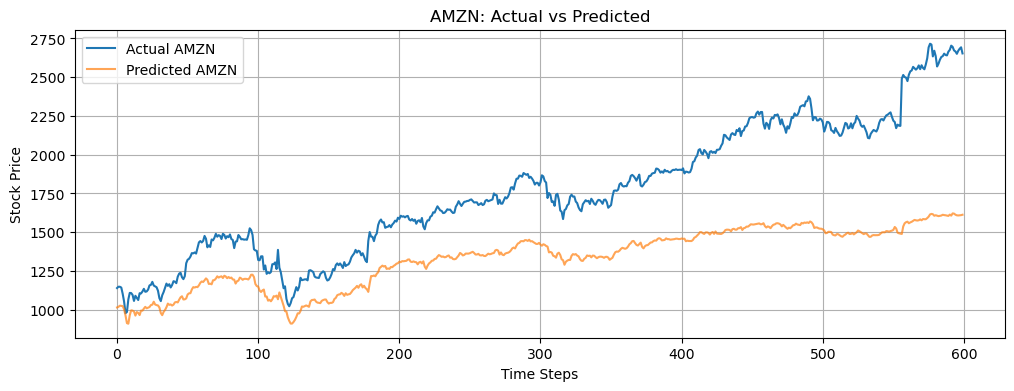

In [133]:
# Predict on the test data
plt.figure(figsize=(12, 4))
plt.plot(y_true[:, 0], label='Actual AMZN')
plt.plot(y_pred[:, 0], label='Predicted AMZN', alpha=0.7)
plt.title("AMZN: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

Observation and overall steps :

1.With simple RNN I could see model is diverging completly aafter ~200 time steps 

A Simple RNN with 64 units may be too shallow to capture long-term dependencies.

RNNs struggle with long sequences.

Gradients from later steps become too small to update early weights effectively.

It learns short-term patterns, not long-term trends.


With GRU this problem could be avoided , However I see my model is still diverging ,could be due to some scaling issue .That has to be looked upen 
    further .